Fine-Tuned GBR MAE: 0.1917
Fine-Tuned GBR MSE: 0.0904
Fine-Tuned GBR R²: -0.1066
Model and Scaler saved successfully!
Predicted Rating for Example (Optimized): 3.08


c:\Users\zaina\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


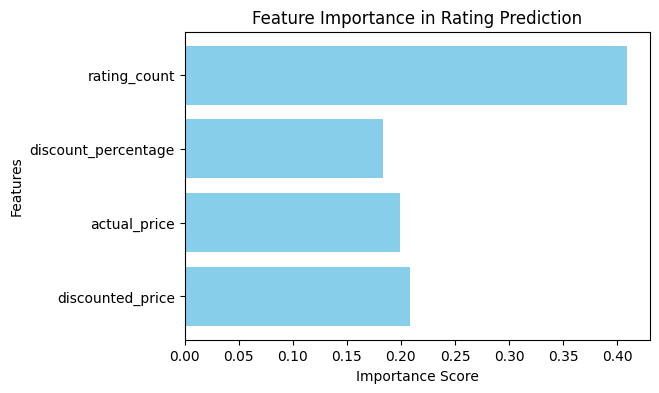

In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load and preprocess dataset
def load_and_clean_data(filepath):
    df = pd.read_csv(filepath)
    features = ["discounted_price", "actual_price", "discount_percentage", "rating_count"]
    
    # Drop rows with missing target values
    df = df.dropna(subset=["rating"])
    
    # Clean and convert numeric columns
    for col in features + ["rating"]:
        df[col] = df[col].replace(r'[^\d.]', '', regex=True)  # Remove non-numeric characters
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric; invalid entries become NaN
    
    # Fill missing values with column median
    for col in features + ["rating"]:
        df[col] = df[col].fillna(df[col].median())
    
    return df

# Load cleaned dataset
data = load_and_clean_data("cleaned-ds_amazon.csv")

# Features and target
features = ["discounted_price", "actual_price", "discount_percentage", "rating_count"]
target = "rating"

# Split data into features and target
X = data[features]
y = data[target]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Fine-Tuned Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(
    n_estimators=500,    # More trees = better accuracy
    learning_rate=0.05,  # Lower learning rate for finer adjustments
    max_depth=6,         # Capture deeper relationships
    subsample=0.9,       # Slightly higher subsampling for better learning
    random_state=42
)
gbr_model.fit(X_train, y_train)

# Evaluate the model
y_pred = gbr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Fine-Tuned GBR MAE: {mae:.4f}")
print(f"Fine-Tuned GBR MSE: {mse:.4f}")
print(f"Fine-Tuned GBR R²: {r2:.4f}")

# Save the trained model and scaler
joblib.dump(gbr_model, "rating_gbr_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and Scaler saved successfully!")

# Test on example product
example_product = np.array([[790.0, 1999.0, 60.0, 103]])  # Example product inputs
example_scaled = scaler.transform(example_product)
example_prediction = gbr_model.predict(example_scaled)[0]

print(f"Predicted Rating for Example (Optimized): {example_prediction:.2f}")

# Feature Importance Analysis
import matplotlib.pyplot as plt
feature_importance = gbr_model.feature_importances_

plt.figure(figsize=(6, 4))
plt.barh(features, feature_importance, color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Rating Prediction")
plt.show()
